## ATAC + MULTIOME GERM CELLS (july 2021)

### Convert to Seurat objects for CICERO

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata


In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
backcall            0.2.0
cairo               1.20.0
cffi                1.14.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
markupsafe          1.1.1
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.21.2
packaging           20.9
pandas              1.2.1
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_res

In [5]:
print(anndata2ri.__version__)
print(anndata.__version__)

1.0.6
0.7.5


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R

library(Signac)
library(Seurat)
library(SeuratDisk)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

For future reference most packages were installed here: */tmp/RtmpGjkK1o/downloaded_packages/*

**Set directories**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/germcells_july2021/"
experiment_prefix = 'germcells_'

#### Convert the h5ad created with cisTopic into a Seurat object with peaks assay

In [9]:
ATAC_scanpy = sc.read_h5ad(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")
ATAC_scanpy

AnnData object with n_obs × n_vars = 8901 × 120127
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'PGC', 'GC', 'oocyte', 'pre_oocyte', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max', 'leiden_R', 'cell_type'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellatac_clusters_colors', 'germ_colors', 'germcells_colors', 'individual_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'multiome_GermCells_colors', 'neighbors', 'sample

In [10]:
ATAC_scanpy.X

<8901x120127 sparse matrix of type '<class 'numpy.float32'>'
	with 29789785 stored elements in Compressed Sparse Row format>

In [11]:
binary_raw = ATAC_scanpy.layers['binary_raw']
binary_raw

<8901x120127 sparse matrix of type '<class 'numpy.float32'>'
	with 29789785 stored elements in Compressed Sparse Row format>

In [12]:
binary_raw.shape

(8901, 120127)

Step 1: from sparse matrix (python format) to dgcMatrix (R format)

I found this function here: <https://github.com/theislab/anndata2ri/issues/8>

In [7]:
import numpy as np
from scipy import sparse

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter

ro.r("library(Matrix)")

def csr_to_dgc(csr):
    """Convert (and transpose) a csr matrix from python to a R dgCMatrix (not sure if type is consistent)
    """
    numeric = ro.r("as.numeric")
    with localconverter(ro.default_converter + ro.numpy2ri.converter):
        X = ro.r("sparseMatrix")(
            i=numeric(csr.indices),
            p=numeric(csr.indptr),
            x=numeric(csr.data),
            dims=list(csr.shape[::-1]),
            index1=False
        )
    return X

In [10]:
print(rpy2.__version__)

3.4.2


In [14]:
ATAC_R = csr_to_dgc(binary_raw)
ATAC_R

<rpy2.robjects.methods.RS4 object at 0x7f642ec6e280> [RTYPES.S4SXP]
R classes: ('dgCMatrix',)

In [15]:
%%R -i ATAC_R -o ATAC_dgT

ATAC_dgT <- as(ATAC_R, "dgTMatrix")
print(dim(ATAC_dgT)) # Check the shape of the matrix 

[1] 120127   8901


Step 2: save metadata per cell and per peak and add colnames and rownames to the peak matrix

In [16]:
metadata_cell = ATAC_scanpy.obs
metadata_peak = ATAC_scanpy.var
layers = ATAC_scanpy.layers
reduction_cistopic = ATAC_scanpy.obsm['X_cistopic_30']
reduction_umap = ATAC_scanpy.obsm['X_umap']
reduction_harmony = ATAC_scanpy.obsm['X_harmony']

In [17]:
del ATAC_scanpy.obs['cellatac_clusters']

In [18]:
%%R -i ATAC_dgT -i metadata_cell -i metadata_peak 

rownames(ATAC_dgT) <- rownames(metadata_peak) # Add rownames to peak matrix
colnames(ATAC_dgT) <- rownames(metadata_cell) # Add colnames to peak matrix 

In [19]:
%%R 
print(head(rownames(ATAC_dgT)))
print(head(colnames(ATAC_dgT)))
print(names(ATAC_dgT))

[1] "chr1:818667-818886" "chr1:827077-827691" "chr1:869540-870172"
[4] "chr1:876378-877525" "chr1:902611-903058" "chr1:904097-904383"
[1] "01-AAACAGCCAGCCAGAA-1" "01-AAACAGCCATCCAGGT-1" "01-AAACATGCATTGTCCT-1"
[4] "01-AAACCGAAGCTTCCCG-1" "01-AAACCGAAGGCGAATA-1" "01-AAACCGAAGTTCCTGC-1"
NULL


Step 3: build ChromatinAssay with peaks x cells matrix 

In [20]:
%%R -o chrom_assay 

 chrom_assay <- CreateChromatinAssay(
    counts = ATAC_dgT,
    sep = c(":", "-"),
    genome = "hg38",
    ranges = NULL,
 )
chrom_assay

ChromatinAssay data with 120127 features for 8901 cells
Variable features: 0 
Genome: hg38 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 0 


Step 4: build Seurat object from chromatin assay 

In [21]:
%%R -o ATAC_Seurat -i metadata_cell

ATAC_Seurat <- CreateSeuratObject(
    counts = chrom_assay,
    assay = "peaks",
    meta.data = metadata_cell,
  )
ATAC_Seurat

An object of class Seurat 
120127 features across 8901 samples within 1 assay 
Active assay: peaks (120127 features, 0 variable features)


In [22]:
%%R 
print(table(ATAC_Seurat@meta.data$individual))
print(table(ATAC_Seurat@meta.data$cell_type))


  F81  Hrv3 Hrv10 Hrv13 Hrv15 Hrv17 Hrv18 Hrv21 Hrv39 Hrv41 Hrv49 Hrv50 Hrv54 
   15   604     5    55    70     2    14     9   660   141   188   542   345 
Hrv55 Hrv58 Hrv59 Hrv65 Hrv91 Hrv92 
   92  1903   266  2596  1089   305 

              PGC                GC     oogonia_STRA8   oogonia_meiotic 
             3016               903              2467              1466 
       pre_oocyte            oocyte pre_spermatogonia 
              148               442               459 


Step 5: Add dimensionality reductions to Seurat object 

In [23]:
%%R -i reduction_cistopic -i metadata_cell -o reduction_cistopic_2 

reduction_cistopic_2 <- data.matrix(reduction_cistopic)
key <- "cisTopic_"
colnames(reduction_cistopic_2) <- paste0(key, 1:ncol(x = reduction_cistopic_2))
rownames(reduction_cistopic_2) <- rownames(metadata_cell)
#print(head(reduction_cistopic_2))

In [24]:
%%R -i reduction_umap -i metadata_cell -o reduction_umap_2 

reduction_umap_2 <- data.matrix(reduction_umap)
key2 <- "UMAP_"
colnames(reduction_umap_2) <- paste0(key2, 1:ncol(x = reduction_umap_2))
rownames(reduction_umap_2) <- rownames(metadata_cell)
#print(head(reduction_umap_2))

In [25]:
%%R -i reduction_harmony -i metadata_cell -o reduction_harmony_2 

reduction_harmony_2 <- data.matrix(reduction_harmony)
key3 <- "Harmony_"
colnames(reduction_harmony_2) <- paste0(key3, 1:ncol(x = reduction_harmony_2))
rownames(reduction_harmony_2) <- rownames(metadata_cell)
#print(head(reduction_harmony_2))

In [26]:
%%R 

ATAC_Seurat@reductions$cisTopics <- CreateDimReducObject(embeddings = reduction_cistopic_2, assay = "peaks")
ATAC_Seurat@reductions$umap <- CreateDimReducObject(embeddings = reduction_umap_2, assay = "peaks")
ATAC_Seurat@reductions$harmony <- CreateDimReducObject(embeddings = reduction_harmony_2, assay = "peaks")
ATAC_Seurat

An object of class Seurat 
120127 features across 8901 samples within 1 assay 
Active assay: peaks (120127 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


### Save RDS object of germ cells 

In [27]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat, file = paste0(outdir, experiment_prefix, "_full.rds"))

In [28]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat <- readRDS(file = paste0(outdir, experiment_prefix, "_full.rds"))

## TF motifs with ChromVar

#### Add motifs

In [29]:
%%R -o pfm

# Get a list of motif position frequency matrices from the JASPAR, HOCOMOCO, HOMER and SwissRegulon databases
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv10')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from SwissRegulon                       
tf_motif_SwissRegulon=subset(MotifDb, organism=='Hsapiens' & dataSource=='SwissRegulon')
pfmSwissRegulon = convert_motifs(tf_motif_SwissRegulon, 'TFBSTools-PWMatrix')
pfmSwissRegulon_names =  sapply(pfmSwissRegulon, function(x) x@ID)
names(tf_motif_SwissRegulon) = pfmSwissRegulon_names
for (i in 1:length(pfmSwissRegulon) ){
    # Convert into a PCM
    x = t(pfmSwissRegulon[[i]]@profileMatrix) - apply(pfmSwissRegulon[[i]]@profileMatrix, 2, min) # normalize per column
    pfmSwissRegulon[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmSwissRegulon[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmSwissRegulon_names[i]]] <- pfmSwissRegulon[[i]]
}


# add data from HOMER                       
tf_motif_HOMER=subset(MotifDb, dataSource=='HOMER')
pfmHOMER = convert_motifs(tf_motif_HOMER, 'TFBSTools-PWMatrix')
pfmHOMER_names =  sapply(pfmHOMER, function(x) x@ID)
names(pfmHOMER) = paste0( sapply( strsplit(pfmHOMER_names, '\\('), head, 1), '.HOMER')
#print(names(pfmHOMER))
names(pfmHOMER)[93] = "FOXL2.HOMER"
 
pfmHOMER = pfmHOMER[ grep('[a-z]',  names(pfmHOMER), invert = T) ] # remove non-human (lowercase)
#print(names(pfmHOMER))

for (i in 1:length(pfmHOMER) ){
    # Convert into a PCM
    x = t(pfmHOMER[[i]]@profileMatrix) - apply(pfmHOMER[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHOMER[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHOMER[[i]]@profileMatrix) <- 'integer'
    pfmHOMER[[i]]@name = gsub('.HOMER', '', names(pfmHOMER)[i])
    pfm[[names(pfmHOMER)[i]]] <- pfmHOMER[[i]]
}


# Add name in id
idx =  grep('^MA', names(pfm) )
for (i in idx ){
    pfm[[i]]@ID = paste0(pfm[[i]]@name, '.', pfm[[i]]@ID)
    names(pfm)[i] = pfm[[i]]@ID
}

# remove pcm with NAs
pfm = pfm[ ! sapply(pfm, function(x) any(is.na(x@profileMatrix))) ]

length(pfm)
table(unlist(sapply(pfm, function(x) x@tags$dataSource)))

[1] 638 147 683


#### Add motifs

In [30]:
%%R -o ATAC_Seurat_withMotifs

ATAC_Seurat_withMotifs <- AddMotifs(object = ATAC_Seurat, 
                         genome= BSgenome.Hsapiens.UCSC.hg38, 
                         pfm = pfm, 
                         assay = "peaks", 
                         verbose = TRUE)

ATAC_Seurat_withMotifs

An object of class Seurat 
120127 features across 8901 samples within 1 assay 
Active assay: peaks (120127 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


#### Compute per-cell motif activity scores with chromVar

In [31]:
%%R -o ATAC_Seurat_withChromVar

library(BiocParallel)
register(SerialParam())
ATAC_Seurat_withChromVar <- RunChromVAR(
  object = ATAC_Seurat_withMotifs,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  assay="peaks"
)
ATAC_Seurat_withChromVar

An object of class Seurat 
122047 features across 8901 samples within 2 assays 
Active assay: peaks (120127 features, 0 variable features)
 1 other assay present: chromvar
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [32]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat_withChromVar, file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))

In [33]:
%%R -i pfm -o motif2names

library(dplyr) 
motif2names <- lapply(pfm, function(x) x@name)
names(motif2names) <- sapply(pfm, function(x) x@ID) %>% gsub('_', '-', .)

In [34]:
%%R 

DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 

In [35]:
%%R 

Idents(ATAC_Seurat_withChromVar) <- ATAC_Seurat_withChromVar@meta.data$cell_type
print(table(Idents(ATAC_Seurat_withChromVar)))


              PGC                GC     oogonia_STRA8   oogonia_meiotic 
             3016               903              2467              1466 
       pre_oocyte            oocyte pre_spermatogonia 
              148               442               459 


In [36]:
%%R -i outdir -o all_da_peaks

all_da_peaks = FindAllMarkers(ATAC_Seurat_withChromVar, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1)
write.csv(all_da_peaks, file = paste0(outdir, 'TFs/DARs/all_DA_peaks_LR.csv'))

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03m 18s       |++                                                | 2 % ~03m 22s       |++                                                | 3 % ~03m 24s       |+++                                               | 4 % ~03m 23s       |+++                                               | 5 % ~03m 22s       |++++                                              | 6 % ~03m 20s       |++++                                              | 7 % ~03m 13s       |+++++                                             | 8 % ~03m 04s       |+++++                                             | 9 % ~02m 56s       |++++++                                            | 10% ~02m 50s       |++++++                                            | 11% ~02m 45s       |+++++++                                           | 12% ~02m 40s       |+++++++                                           | 13% ~02m 

#### z-scores per cell type annotation

In [37]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat_withChromVar <- readRDS(file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))
DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 
ATAC_Seurat_withChromVar

An object of class Seurat 
122047 features across 8901 samples within 2 assays 
Active assay: chromvar (1920 features, 0 variable features)
 1 other assay present: peaks
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [38]:
%%R -o chromvar_assay

chromvar_assay <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_Seurat_withChromVar))))

In [39]:
chromvar_assay.shape

(8901, 1920)

In [40]:
# Mapping of cells to cell types 
ATAC_scanpy.obs['barcode'] = ATAC_scanpy.obs_names
cells_celltypes = ATAC_scanpy.obs[['barcode', 'cell_type']]
cells_celltypes.head()

,barcode,cell_type
01-AAACAGCCAGCCAGAA-1,01-AAACAGCCAGCCAGAA-1,oogonia_STRA8
01-AAACAGCCATCCAGGT-1,01-AAACAGCCATCCAGGT-1,oogonia_STRA8
01-AAACATGCATTGTCCT-1,01-AAACATGCATTGTCCT-1,oogonia_STRA8
01-AAACCGAAGCTTCCCG-1,01-AAACCGAAGCTTCCCG-1,pre_oocyte
01-AAACCGAAGGCGAATA-1,01-AAACCGAAGGCGAATA-1,oogonia_STRA8


In [41]:
cells_mapping_clusters = cells_celltypes.groupby('cell_type').groups

In [42]:
# Mean by rows 
for key in cells_mapping_clusters: 
    print(key)
    chromvar_assay.loc[key] = chromvar_assay.loc[cells_mapping_clusters[key]].mean(axis = 0)

PGC
GC
oogonia_STRA8
oogonia_meiotic
pre_oocyte
oocyte
pre_spermatogonia


In [43]:
rows_celltypes = list(np.unique(cells_celltypes['cell_type']))
print(rows_celltypes)
# Select only aggregated rows
chromvar_assay = chromvar_assay.loc[rows_celltypes, ]

['GC', 'PGC', 'oocyte', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_oocyte', 'pre_spermatogonia']


In [44]:
# Normalize by column (TF)
from scipy.stats import zscore
chromvar_assay_zscore = chromvar_assay.apply(zscore)

In [45]:
chromvar_assay_zscore.to_csv(outdir + experiment_prefix + "_chromvar_celltype_zscore.csv")

In [10]:
chromvar_assay_zscore = pd.read_csv(outdir + experiment_prefix + "_chromvar_celltype_zscore.csv", index_col = 0)

In [11]:
chromvar_assay_zscore = chromvar_assay_zscore.reindex([ 'PGC', 'GC', 'oogonia_STRA8', 'oogonia_meiotic',
                                                       'pre_oocyte','oocyte',  'pre_spermatogonia'])


In [12]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [13]:
import seaborn as sns
my_cmap = sns.diverging_palette(240, 10, s = 100, l = 40,n=10, as_cmap=True)


In [14]:
chromvar_assay_zscore.shape

(7, 1920)

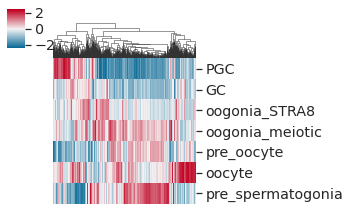

In [18]:
sns.set(font_scale=1.3)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(5, 3),
                         cmap = my_cmap)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_july2021/figures_germ/heatmap_germcells_TFs.pdf")


#### End of notebook

In [13]:
tfs_da = pd.read_csv(outdir + 'TFs/DARs/all_DA_peaks_LR.csv', index_col = 0)
tfs_da

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
TFAP2B(var.2).MA0812.1,0.000000,14.532986,0.881,0.230,0.0,PGC,TFAP2B(var.2).MA0812.1
TFAP2A.MA0003.3,0.000000,13.920319,0.883,0.231,0.0,PGC,TFAP2A.MA0003.3
TFAP2B.MA0811.1,0.000000,13.084652,0.898,0.214,0.0,PGC,TFAP2B.MA0811.1
TFAP2C.MA0524.2,0.000000,12.551416,0.891,0.229,0.0,PGC,TFAP2C.MA0524.2
AP2A-HUMAN.H10MO.C,0.000000,11.818874,0.914,0.243,0.0,PGC,AP2A-HUMAN.H10MO.C
...,...,...,...,...,...,...,...
MITF.MA0620.2.6,0.978285,-2.726821,0.503,0.471,1.0,pre_spermatogonia,MITF.MA0620.2
PBX2.MA1113.1.6,0.984087,-0.110353,0.475,0.477,1.0,pre_spermatogonia,PBX2.MA1113.1
GSC2.SwissRegulon.6,0.993576,-0.064550,0.495,0.494,1.0,pre_spermatogonia,GSC2.SwissRegulon
ONECUT3.MA0757.1.6,0.995726,0.058047,0.458,0.482,1.0,pre_spermatogonia,ONECUT3.MA0757.1


In [14]:
for c in np.unique(tfs_da['cluster']):
    print(c)
    print(tfs_da[tfs_da['cluster'] == c].shape)

GC
(1852, 7)
PGC
(1852, 7)
oocyte
(1852, 7)
oogonia_STRA8
(1852, 7)
oogonia_meiotic
(1852, 7)
pre_oocyte
(1852, 7)
pre_spermatogonia
(1852, 7)
